In [ ]:
!pip install -U deep-translator

In [ ]:
!pip install transformers[sentencepiece] ## for joeddav/xlm-roberta-large-xnli

In [ ]:
!pip install spacy

In [ ]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
!pip3 install googletrans==4.0.0-rc1 --user

In [ ]:
!pip3 install git+https://github.com/huggingface/transformers --user

# This notebook uses the results of KeyBERT from Part 1
### Here, we use the Zero Shot Classication method to generate the probability that a given keyword/phrase/sentence is associated with a given theme. 

For example, given:
- A set of themes: [time, nation, nature]
- A phrase to be classified: "getting old" 

We would expected that the phrase above is associated with "time". The Zero Shot Classification generates probabilities for each of the themes, time, nation and nature in this case, e.g. [{time: 0.88}, {nature: 0.10}, {nation: 0.02}]

We would then predict the "most likely" theme to be "time".

In [38]:
import pandas as pd
from googletrans import Translator
import time
from transformers import pipeline
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import spacy

In [ ]:
from deep_translator import GoogleTranslator

In [4]:
data = pd.read_csv("https://github.com/winfreykong/BERT-Poem/blob/main/Data/With%20GPU/keyword_poems.csv?raw=true").drop(columns=['Unnamed: 0'])
data.head()

ID         poem_author   language  \
0   1         Halyna Kruk  Ukrainian   
1   2     Ostap Slyvynsky  Ukrainian   
2   3     Osip Mandelstam    Russian   
3   4    Boris Khersonsky    Russian   
4   5  Oleksandr Irvanets  Ukrainian   

                                       original_poem  \
0  ***\ncказати собі чесно, якомога чесніше,\nтак...   
1  ХАЙКУ З МАЙДАНУ\nДим у рукавах.\nНіби йдеш з ц...   
2  (О.М.)\nНе мучнистой бабочкою белой\nВ землю я...   
3  ***\n"Союз нерушимый" сыграют и хором споют.\n...   
4  ***\nЦей рік, який почався з середи - \nКуди в...   

                                    light_clean_poem  \
0  *** cказати собі чесно, якомога чесніше, так н...   
1  ХАЙКУ З МАЙДАНУ Дим у рукавах. Ніби йдеш з цим...   
2   Не мучнистой бабочкою белой В землю я заемный...   
3  *** "Союз нерушимый" сыграют и хором споют. В ...   
4  *** Цей рік, який почався з середи -  Куди він...   

                                               theme  \
0     {'ukraine', 'maidan', 'revolution', 'protest'}   
1  {'revolution', 'poetic form', 'maidan', 'haiku...   
2               {'time', 'twentieth century', 'war'}   
3     {'food', 'soviet union', 'morphine', 'anthem'}   
4                    {'time', 'new year', 'seasons'}   

                                            keywords  
0  [('покладаючись', 0.3382), ('патріотичних', 0....  
1  [('пообіцяти', 0.4741), ('пустимо', 0.3054), (...  
2  [('восклицанья', 0.3814), ('мыслящее', 0.2992)...  
3  [('проснусь', 0.3366), ('нерушимый', 0.331), (...  
4  [('наступний', 0.4395), ('четверга', 0.2653), ...

In [5]:
data.shape

(1010, 7)

In [6]:
data = data.assign(keywords_ori = data['keywords'].apply(lambda x: [i[0] if (isinstance(i[0], str) and not i[0].isdigit()) else '' for i in eval(x)]))
data.head()

ID         poem_author   language  \
0   1         Halyna Kruk  Ukrainian   
1   2     Ostap Slyvynsky  Ukrainian   
2   3     Osip Mandelstam    Russian   
3   4    Boris Khersonsky    Russian   
4   5  Oleksandr Irvanets  Ukrainian   

                                       original_poem  \
0  ***\ncказати собі чесно, якомога чесніше,\nтак...   
1  ХАЙКУ З МАЙДАНУ\nДим у рукавах.\nНіби йдеш з ц...   
2  (О.М.)\nНе мучнистой бабочкою белой\nВ землю я...   
3  ***\n"Союз нерушимый" сыграют и хором споют.\n...   
4  ***\nЦей рік, який почався з середи - \nКуди в...   

                                    light_clean_poem  \
0  *** cказати собі чесно, якомога чесніше, так н...   
1  ХАЙКУ З МАЙДАНУ Дим у рукавах. Ніби йдеш з цим...   
2   Не мучнистой бабочкою белой В землю я заемный...   
3  *** "Союз нерушимый" сыграют и хором споют. В ...   
4  *** Цей рік, який почався з середи -  Куди він...   

                                               theme  \
0     {'ukraine', 'maidan', 'revolution', 'protest'}   
1  {'revolution', 'poetic form', 'maidan', 'haiku...   
2               {'time', 'twentieth century', 'war'}   
3     {'food', 'soviet union', 'morphine', 'anthem'}   
4                    {'time', 'new year', 'seasons'}   

                                            keywords  \
0  [('покладаючись', 0.3382), ('патріотичних', 0....   
1  [('пообіцяти', 0.4741), ('пустимо', 0.3054), (...   
2  [('восклицанья', 0.3814), ('мыслящее', 0.2992)...   
3  [('проснусь', 0.3366), ('нерушимый', 0.331), (...   
4  [('наступний', 0.4395), ('четверга', 0.2653), ...   

                                        keywords_ori  
0  [покладаючись, патріотичних, втікаючи, хочу, м...  
1  [пообіцяти, пустимо, вистоїмо, лісистим, хребтом]  
2  [восклицанья, мыслящее, молчаливо, позвоночное...  
3  [проснусь, нерушимый, скрывать, подсыхает, кус...  
4  [наступний, четверга, кочерга, почнеться, прямим]

### To begin with, we will focus on training our model in English. We will need to translate the keyword/phrase/sentence into English

In [4]:
def translate(text):
    translator = Translator()
    return translator.translate(text, dest='en').text

In [5]:
def translate_v2(text):
    translator = GoogleTranslator(source='auto', target='en')
    return translator.translate_batch(text)

In [ ]:
data[:5]['keywords_ori']

0    [покладаючись, патріотичних, втікаючи, хочу, м...
1    [пообіцяти, пустимо, вистоїмо, лісистим, хребтом]
2    [восклицанья, мыслящее, молчаливо, позвоночное...
3    [проснусь, нерушимый, скрывать, подсыхает, кус...
4    [наступний, четверга, кочерга, почнеться, прямим]
Name: keywords_ori, dtype: object

In [ ]:
translate('покладаючись')

'relying'

### Testing which translation package runs faster

In [ ]:
%%timeit
data[:10]['keywords_ori'].apply(lambda x: [translate(i) for i in x])

The slowest run took 6.35 times longer than the fastest. This could mean that an intermediate result is being cached.
11.5 s ± 8.57 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
data[:10]['keywords_ori'].apply(translate_v2)

6.07 s ± 1.12 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### We will use the Google Translator from Deep Translator for batch translation

In [ ]:
keywords_eng = data['keywords_ori'].apply(translate_v2)

In [ ]:
data = data.assign(keywords_eng=keywords_eng)
data.to_csv('keyword_eng_poems.csv')

In [ ]:
data.head()

ID         poem_author   language  \
0   1         Halyna Kruk  Ukrainian   
1   2     Ostap Slyvynsky  Ukrainian   
2   3     Osip Mandelstam    Russian   
3   4    Boris Khersonsky    Russian   
4   5  Oleksandr Irvanets  Ukrainian   

                                       original_poem  \
0  ***\ncказати собі чесно, якомога чесніше,\nтак...   
1  ХАЙКУ З МАЙДАНУ\nДим у рукавах.\nНіби йдеш з ц...   
2  (О.М.)\nНе мучнистой бабочкою белой\nВ землю я...   
3  ***\n"Союз нерушимый" сыграют и хором споют.\n...   
4  ***\nЦей рік, який почався з середи - \nКуди в...   

                                    light_clean_poem  \
0  *** cказати собі чесно, якомога чесніше, так н...   
1  ХАЙКУ З МАЙДАНУ Дим у рукавах. Ніби йдеш з цим...   
2   Не мучнистой бабочкою белой В землю я заемный...   
3  *** "Союз нерушимый" сыграют и хором споют. В ...   
4  *** Цей рік, який почався з середи -  Куди він...   

                                               theme  \
0     {'ukraine', 'maidan', 'revolution', 'protest'}   
1  {'revolution', 'poetic form', 'maidan', 'haiku...   
2               {'time', 'twentieth century', 'war'}   
3     {'food', 'soviet union', 'morphine', 'anthem'}   
4                    {'time', 'new year', 'seasons'}   

                                            keywords  \
0  [('покладаючись', 0.3382), ('патріотичних', 0....   
1  [('пообіцяти', 0.4741), ('пустимо', 0.3054), (...   
2  [('восклицанья', 0.3814), ('мыслящее', 0.2992)...   
3  [('проснусь', 0.3366), ('нерушимый', 0.331), (...   
4  [('наступний', 0.4395), ('четверга', 0.2653), ...   

                                        keywords_ori  \
0  [покладаючись, патріотичних, втікаючи, хочу, м...   
1  [пообіцяти, пустимо, вистоїмо, лісистим, хребтом]   
2  [восклицанья, мыслящее, молчаливо, позвоночное...   
3  [проснусь, нерушимый, скрывать, подсыхает, кус...   
4  [наступний, четверга, кочерга, почнеться, прямим]   

                                        keywords_eng  
0  [relying on, patriotic, running away, Want, sm...  
1  [to promise, let's go, let's stand, wooded, sp...  
2  [exclamations, thinking, silently, vertebrate,...  
3  [wake up, indestructible, hide, dries up, a pi...  
4   [following, Thursday, poker, will begin, direct]

# Generating theme (topic modelling) based on english keywords 

In [ ]:
data = pd.read_csv("keyword_eng_poems.csv").drop(columns=['Unnamed: 0'])

In [ ]:
data.shape

(1010, 9)

In [ ]:
data

ID         poem_author   language  \
0        1         Halyna Kruk  Ukrainian   
1        2     Ostap Slyvynsky  Ukrainian   
2        3     Osip Mandelstam    Russian   
3        4    Boris Khersonsky    Russian   
4        5  Oleksandr Irvanets  Ukrainian   
...    ...                 ...        ...   
1005  1201       Oleh Kotsarev  Ukrainian   
1006  1202     Olena Huseinova  Ukrainian   
1007  1203     Pavlo Korobchuk  Ukrainian   
1008  1204    Victoria Amelina  Ukrainian   
1009  1205            Iya Kiva  Ukrainian   

                                          original_poem  \
0     ***\ncказати собі чесно, якомога чесніше,\nтак...   
1     ХАЙКУ З МАЙДАНУ\nДим у рукавах.\nНіби йдеш з ц...   
2     (О.М.)\nНе мучнистой бабочкою белой\nВ землю я...   
3     ***\n"Союз нерушимый" сыграют и хором споют.\n...   
4     ***\nЦей рік, який почався з середи - \nКуди в...   
...                                                 ...   
1005  СВІТ САМШИТ\n\nСвіте!\nХиткий самшите!\nГладжу...   
1006  Дорога Halyna Kruk :\nале з кожною розповіддю ...   
1007  - у мене закінчуються сили, я не в ресурсі\n- ...   
1008  *\nдивне пекуче літо\nповне людей із моря\nїхн...   
1009  тримати у роті голку мовчання\nзшивати слова б...   

                                       light_clean_poem  \
0     *** cказати собі чесно, якомога чесніше, так н...   
1     ХАЙКУ З МАЙДАНУ Дим у рукавах. Ніби йдеш з цим...   
2      Не мучнистой бабочкою белой В землю я заемный...   
3     *** "Союз нерушимый" сыграют и хором споют. В ...   
4     *** Цей рік, який почався з середи -  Куди він...   
...                                                 ...   
1005  СВІТ САМШИТ  Світе! Хиткий самшите! Гладжу теб...   
1006  Дорога Halyna Kruk : але з кожною розповіддю м...   
1007  - у мене закінчуються сили, я не в ресурсі - а...   
1008  * дивне пекуче літо повне людей із моря їхні с...   
1009  тримати у роті голку мовчання зшивати слова бі...   

                                                  theme  \
0        {'ukraine', 'maidan', 'revolution', 'protest'}   
1     {'revolution', 'poetic form', 'maidan', 'haiku...   
2                  {'time', 'twentieth century', 'war'}   
3        {'food', 'soviet union', 'morphine', 'anthem'}   
4                       {'time', 'new year', 'seasons'}   
...                                                 ...   
1005                                  {'nature', 'art'}   
1006  {'poetry', 'lazarus', 'religion', 'ukraine', '...   
1007  {'ukraine', 'reportage', 'war', 'ammunition', ...   
1008  {'mariupol', 'souvenirs', 'archive', 'summer',...   
1009            {'needle', 'speech', 'silence', 'pain'}   

                                               keywords  \
0     [('покладаючись', 0.3382), ('патріотичних', 0....   
1     [('пообіцяти', 0.4741), ('пустимо', 0.3054), (...   
2     [('восклицанья', 0.3814), ('мыслящее', 0.2992)...   
3     [('проснусь', 0.3366), ('нерушимый', 0.331), (...   
4     [('наступний', 0.4395), ('четверга', 0.2653), ...   
...                                                 ...   
1005  [('обганяємо', 0.4533), ('порозкуйовдити', 0.4...   
1006  [('літературу', 0.3972), ('розповіддю', 0.3832...   
1007  [('багатомільйонного', 0.4426), ('настільки', ...   
1008  [('маріуполя', 0.2747), ('прокурори', 0.2465),...   
1009  [('дірявому', 0.2262), ('білими', 0.2193), ('ц...   

                                           keywords_ori  \
0     ['покладаючись', 'патріотичних', 'втікаючи', '...   
1     ['пообіцяти', 'пустимо', 'вистоїмо', 'лісистим...   
2     ['восклицанья', 'мыслящее', 'молчаливо', 'позв...   
3     ['проснусь', 'нерушимый', 'скрывать', 'подсыха...   
4     ['наступний', 'четверга', 'кочерга', 'почнетьс...   
...                                                 ...   
1005  ['обганяємо', 'порозкуйовдити', 'невпіймані', ...   
1006  ['літературу', 'розповіддю', 'проповідуючи', '...   
1007  ['багатомільйонного', 'настільки', 'щовечора',...   
1008  ['маріуполя', 'прокурори', 'майбутн

### Let's start with performing a quick test

In [11]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [ ]:
sequence_to_classify = "patriotic" 
candidate_labels = ['nation', 'time', 'revolution']
classifier(sequence_to_classify, candidate_labels) #expect "nation"

{'sequence': 'patriotic',
 'labels': ['nation', 'time', 'revolution'],
 'scores': [0.9161605834960938, 0.0708652064204216, 0.012974199838936329]}

In [ ]:
sequence_to_classify = "will begin" 
candidate_labels = ['nation', 'time', 'revolution']
classifier(sequence_to_classify, candidate_labels) #expect "time"

{'sequence': 'will begin',
 'labels': ['time', 'nation', 'revolution'],
 'scores': [0.7398016452789307, 0.15727007389068604, 0.1029282808303833]}

In [ ]:
sequence_to_classify = "mental health" 
candidate_labels = ['nation', 'time', 'revolution', 'psychology']
classifier(sequence_to_classify, candidate_labels) #expect "psychology"

{'sequence': 'mental health',
 'labels': ['psychology', 'time', 'nation', 'revolution'],
 'scores': [0.8121060132980347,
  0.08897802233695984,
  0.0651412159204483,
  0.0337747260928154]}

In [ ]:
sequence_to_classify = "aging" 
candidate_labels = ['nation', 'time', 'revolution', 'psychology']
classifier(sequence_to_classify, candidate_labels) #expect "time"

{'sequence': 'aging',
 'labels': ['time', 'nation', 'psychology', 'revolution'],
 'scores': [0.8773593306541443,
  0.08302872627973557,
  0.024532590061426163,
  0.015079350210726261]}

### Seems to be working pretty well!

## Task breakdown:

Run zero-shot-classification on the "keywords_eng" column (a list of english-translated keywords) with labels being the big themes defined in "Cleaning & KeyBERT Part1"!
- Set score threshold, say 0.70

In [5]:
# Big theme list from "Cleaning & KeyBERT Part1"
big_theme = ['war', 'religion', 'nation', 'death', 'time',
             'protest', 'geography', 'season', 'family', 'language',
             'maidan','memory', 'animal', 'nature', 'love', 'poetry',   
             'psychology', 'politics', 'life', 'fruit', 'gender', 'mythology']

In [6]:
def get_big_theme(keywords_list, big_theme_list, classifier):
    results = []
    for i in keywords_list:
      # if keyword is not None and keyword not ""
        if i and len(i) != 0:
            out = classifier(i, big_theme_list)
            out['scores'] = out['scores'][:3] #getting only the top3
            out['labels'] = out['labels'][:3] #getting only the top3
            results.append(out)
    return results

In [ ]:
eval(data.iloc[3].keywords_eng)

['wake up', 'indestructible', 'hide', 'dries up', 'a piece']

In [ ]:
t1 = get_big_theme(eval(data.iloc[3].keywords_eng), big_theme, classifier)

In [ ]:
t1

[{'sequence': 'wake up',
  'labels': ['time', 'protest', 'life'],
  'scores': [0.37131044268608093, 0.13614800572395325, 0.09478017687797546]},
 {'sequence': 'indestructible',
  'labels': ['maidan', 'nature', 'life'],
  'scores': [0.13711203634738922, 0.13091972470283508, 0.11104417592287064]},
 {'sequence': 'hide',
  'labels': ['time', 'maidan', 'family'],
  'scores': [0.11117197573184967, 0.10484229028224945, 0.09301237761974335]},
 {'sequence': 'dries up',
  'labels': ['time', 'maidan', 'season'],
  'scores': [0.24253885447978973, 0.09031683951616287, 0.08095249533653259]},
 {'sequence': 'a piece',
  'labels': ['maidan', 'time', 'language'],
  'scores': [0.13270139694213867, 0.10248517245054245, 0.07310601323843002]}]

In [ ]:
# Edge case 1: row that contains None entry in list of keywords (probably due to failure to translate)
# We want to make sure that our function is able to skip those "None" entries and run properly
data[data['ID']==776]['keywords_eng'].apply(lambda x: get_big_theme(eval(x), big_theme, classifier))

689    [{'sequence': 'eighteen years old', 'labels': ...
Name: keywords_eng, dtype: object

In [ ]:
# Edge case 2: row that contains empty string, i.e. "" in the list of keywords
eg2 = data[data['ID']==270]['keywords_eng'].apply(lambda x: get_big_theme(eval(x), big_theme, classifier))
eg2

250    [{'sequence': 'April Fool's Day', 'labels': ['...
Name: keywords_eng, dtype: object

In [ ]:
eg2.values

array([list([{'sequence': "April Fool's Day", 'labels': ['time', 'language', 'protest'], 'scores': [0.26816195249557495, 0.10589686781167984, 0.08920233696699142]}, {'sequence': 'guard', 'labels': ['maidan', 'protest', 'time'], 'scores': [0.11082840710878372, 0.10774733871221542, 0.08480575680732727]}, {'sequence': 'a joke', 'labels': ['language', 'maidan', 'gender'], 'scores': [0.2668316066265106, 0.15200957655906677, 0.08019862323999405]}, {'sequence': 'a joke', 'labels': ['language', 'maidan', 'gender'], 'scores': [0.2668316066265106, 0.15200957655906677, 0.08019862323999405]}, {'sequence': 'a joke', 'labels': ['language', 'maidan', 'gender'], 'scores': [0.2668316066265106, 0.15200957655906677, 0.08019862323999405]}])],
      dtype=object)

In [ ]:
# Test on a sample of 10 (top 10 rows) and get the run time
start = time.time()
data['keywords_eng'][:10].apply(lambda x: get_big_theme(eval(x), big_theme, classifier))
end = time.time()
end-start

507.5755834579468

#### Around 270 seconds (4.5 minutes) to process 10 rows

In [ ]:
# On average, we have 5 keywords for each poem
np.mean(data['keywords_eng'].apply(lambda x: len(eval(x))))

4.9970297029702975

In [ ]:
start = time.time()

keyword_eng_theme = []
for i in data['keywords_eng']:
    try:
        keyword_eng_theme.append(get_big_theme(eval(i), big_theme, classifier))
    except Exception:
        keyword_eng_theme.append([])
        print(i)
        
end = time.time()
end-start

In [ ]:
start = time.time()
keyword_eng_theme = data['keywords_eng'].apply(lambda x: get_big_theme(eval(x), big_theme, classifier))
end = time.time()
end-start

In [ ]:
keyword_eng_theme

[[{'sequence': 'relying on',
   'labels': ['maidan', 'family', 'nation'],
   'scores': [0.12305205315351486, 0.10531776398420334, 0.0666816458106041]},
  {'sequence': 'patriotic',
   'labels': ['nation', 'maidan', 'language'],
   'scores': [0.4591561555862427, 0.1214393675327301, 0.08682616800069809]},
  {'sequence': 'running away',
   'labels': ['protest', 'time', 'animal'],
   'scores': [0.1631479114294052, 0.15938355028629303, 0.12018370628356934]},
  {'sequence': 'Want',
   'labels': ['protest', 'maidan', 'language'],
   'scores': [0.1297539621591568, 0.11201462894678116, 0.08314479887485504]},
  {'sequence': 'small town',
   'labels': ['maidan', 'life', 'geography'],
   'scores': [0.2456987351179123, 0.15827718377113342, 0.15817879140377045]}],
 [{'sequence': 'to promise',
   'labels': ['language', 'maidan', 'time'],
   'scores': [0.2872653603553772, 0.10143814235925674, 0.06584929674863815]},
  {'sequence': "let's go",
   'labels': ['time', 'life', 'language'],
   'scores': [0.21

In [ ]:
data = data.assign(keyword_eng_theme=keyword_eng_theme)
data.to_csv("keyword_eng_theme.csv")

# Generating themes based on sentence containing keyword

## Task breakdown:
1. Extract the line that contains the keyword from the original text
2. Translate the line to english
3. Run zero-shot-classification on the english-translated line to match our previously defined big themes!

### Small example

In [10]:
test_poem = data.iloc[4].original_poem
test_keywords = data.iloc[4].keywords_ori
print(data.iloc[4].original_poem)

***
Цей рік, який почався з середи - 
Куди він заведе нас всіх, куди? 
Чи буде він прямим, як кочерга? 
Але наступний рік почнеться з четверга...


In [ ]:
test_keywords

"['наступний', 'четверга', 'кочерга', 'почнеться', 'прямим']"

In [ ]:
test_poem.split("\n")

['***',
 'Цей рік, який почався з середи - ',
 'Куди він заведе нас всіх, куди? ',
 'Чи буде він прямим, як кочерга? ',
 'Але наступний рік почнеться з четверга...']

In [ ]:
# Naive for-looping
sentence_set = []
sentence_set_translated = []
for i in eval(test_keywords):
    for j in test_poem.split("\n"):
        if i in j:
            print(i, j)
            sentence_set.append(j)
set(sentence_set)

наступний Але наступний рік почнеться з четверга...
четверга Але наступний рік почнеться з четверга...
кочерга Чи буде він прямим, як кочерга? 
почнеться Але наступний рік почнеться з четверга...
прямим Чи буде він прямим, як кочерга? 


{'Але наступний рік почнеться з четверга...',
 'Чи буде він прямим, як кочерга? '}

In [ ]:
# A better data structure for efficient search would be a sentence dictionary and word dictionary
# Sentence dictionary will have the number of sentence as key, and text sentence itself as value
sentence_dict = dict((idx, sentence) for idx, sentence in enumerate(test_poem.split("\n")))

In [ ]:
# A word dictionary will have the word of each sentence as key, and the index of the sentence the word is found as value
word_dict = {}
for i in sentence_dict:
    words = re.sub(r'[\.\,\?\:\;\!\*\-\+\&\@\<\>]', '', sentence_dict[i]).split()
    word_dict.update(dict(zip(words, [i]*len(words))))
word_dict

{'Цей': 1,
 'рік': 4,
 'який': 1,
 'почався': 1,
 'з': 4,
 'середи': 1,
 'Куди': 2,
 'він': 3,
 'заведе': 2,
 'нас': 2,
 'всіх': 2,
 'куди': 2,
 'Чи': 3,
 'буде': 3,
 'прямим': 3,
 'як': 3,
 'кочерга': 3,
 'Але': 4,
 'наступний': 4,
 'почнеться': 4,
 'четверга': 4}

In [ ]:
key_sentence = set()
for i in eval(test_keywords):
    sentence_id = word_dict[i]
    key_sentence.add(sentence_dict[sentence_id])
key_sentence

{'Але наступний рік почнеться з четверга...',
 'Чи буде він прямим, як кочерга? '}

In [ ]:
translated = translate_v2(list(key_sentence))
translated

['Will it be straight as a poker?', 'But next year starts on Thursday...']

In [ ]:
# Big theme list from "Cleaning & KeyBERT Part1"
big_theme = ['war', 'religion', 'nation', 'death', 'time',
             'protest', 'geography', 'season', 'family', 'language',
             'maidan','memory', 'animal', 'nature', 'love', 'poetry',   
             'psychology', 'politics', 'life', 'fruit', 'gender', 'mythology']

In [ ]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")
sequence_to_classify = translated[0]
classifier(sequence_to_classify, big_theme)

{'sequence': 'Will it be straight as a poker?',
 'labels': ['language',
  'maidan',
  'nation',
  'protest',
  'time',
  'gender',
  'life',
  'psychology',
  'family',
  'nature',
  'animal',
  'politics',
  'memory',
  'season',
  'geography',
  'mythology',
  'death',
  'war',
  'love',
  'fruit',
  'religion',
  'poetry'],
 'scores': [0.10203450173139572,
  0.09321364760398865,
  0.08782705664634705,
  0.0771658793091774,
  0.071766197681427,
  0.07138112187385559,
  0.06894007325172424,
  0.05154707655310631,
  0.04916727542877197,
  0.04896628484129906,
  0.04168234393000603,
  0.03305824100971222,
  0.03008979558944702,
  0.028898190706968307,
  0.028502605855464935,
  0.02457469329237938,
  0.0215385090559721,
  0.020195934921503067,
  0.015201226808130741,
  0.014040797017514706,
  0.01124081015586853,
  0.008967776782810688]}

In [ ]:
sequence_to_classify = translated[1]
classifier(sequence_to_classify, big_theme)

{'sequence': 'But next year starts on Thursday...',
 'labels': ['time',
  'season',
  'life',
  'nation',
  'maidan',
  'language',
  'family',
  'protest',
  'gender',
  'animal',
  'memory',
  'geography',
  'psychology',
  'nature',
  'death',
  'mythology',
  'politics',
  'religion',
  'love',
  'poetry',
  'war',
  'fruit'],
 'scores': [0.23022563755512238,
  0.18337371945381165,
  0.10486763715744019,
  0.06838299334049225,
  0.06712408363819122,
  0.061745576560497284,
  0.0528094507753849,
  0.032620519399642944,
  0.027655236423015594,
  0.02519214153289795,
  0.024064823985099792,
  0.015775084495544434,
  0.014748132787644863,
  0.013392467983067036,
  0.013248588889837265,
  0.013135777786374092,
  0.012663420289754868,
  0.010304717347025871,
  0.008389896713197231,
  0.007602411322295666,
  0.006375987082719803,
  0.006301686633378267]}

#### Great! Seems like it works on a sentence level too!

### Getting sentences that contain the keywords in the full dataset

In [5]:
big_theme = ['war', 'religion', 'nation', 'death', 'time',
             'protest', 'geography', 'season', 'family', 'language',
             'maidan','memory', 'animal', 'nature', 'love', 'poetry',   
             'psychology', 'politics', 'life', 'fruit', 'gender', 'mythology']

In [7]:
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli")

In [7]:
def generate_sentence_dict(poem):
    return dict((idx, sentence) for idx, sentence in enumerate(poem.split("\n")))

def generate_word_dict(sentence_dict):
    word_dict = {}
    for i in sentence_dict:
        words = re.sub(r'[\.\,\?\:\;\!\*\-\+\&\@\<\>]', '', sentence_dict[i]).split()
        word_dict.update(dict(zip(words, [i]*len(words))))
    return word_dict

def get_key_sentence(keywords, word_dict, sentence_dict):
    key_sentence = set()
    for i in eval(keywords):
        try:
            sentence_id = word_dict[i]
            key_sentence.add(sentence_dict[sentence_id])
        except KeyError:
            continue
    return key_sentence

In [8]:
data = pd.read_csv("https://github.com/winfreykong/BERT-Poem/blob/main/Data/final_keyword_eng_theme.csv?raw=true").drop(columns=['Unnamed: 0'])
print(data.shape)
data.head()

(1010, 10)


ID         poem_author   language  \
0   1         Halyna Kruk  Ukrainian   
1   2     Ostap Slyvynsky  Ukrainian   
2   3     Osip Mandelstam    Russian   
3   4    Boris Khersonsky    Russian   
4   5  Oleksandr Irvanets  Ukrainian   

                                       original_poem  \
0  ***\ncказати собі чесно, якомога чесніше,\nтак...   
1  ХАЙКУ З МАЙДАНУ\nДим у рукавах.\nНіби йдеш з ц...   
2  (О.М.)\nНе мучнистой бабочкою белой\nВ землю я...   
3  ***\n"Союз нерушимый" сыграют и хором споют.\n...   
4  ***\nЦей рік, який почався з середи - \nКуди в...   

                                    light_clean_poem  \
0  *** cказати собі чесно, якомога чесніше, так н...   
1  ХАЙКУ З МАЙДАНУ Дим у рукавах. Ніби йдеш з цим...   
2  (О.М.) Не мучнистой бабочкою белой В землю я з...   
3  *** "Союз нерушимый" сыграют и хором споют. В ...   
4  *** Цей рік, який почався з середи -  Куди він...   

                                               theme  \
0     {'maidan', 'protest', 'revolution', 'ukraine'}   
1  {'haiku', 'protest', 'revolution', 'poetic for...   
2               {'time', 'war', 'twentieth century'}   
3     {'soviet union', 'anthem', 'morphine', 'food'}   
4                    {'time', 'new year', 'seasons'}   

                                            keywords  \
0  [('покладаючись', 0.3382), ('патріотичних', 0....   
1  [('пообіцяти', 0.4741), ('пустимо', 0.3054), (...   
2  [('восклицанья', 0.381), ('мыслящее', 0.3004),...   
3  [('проснусь', 0.3366), ('нерушимый', 0.331), (...   
4  [('наступний', 0.4395), ('четверга', 0.2653), ...   

                                        keywords_ori  \
0  ['покладаючись', 'патріотичних', 'втікаючи', '...   
1  ['пообіцяти', 'пустимо', 'вистоїмо', 'лісистим...   
2  ['восклицанья', 'мыслящее', 'молчаливо', 'позв...   
3  ['проснусь', 'нерушимый', 'скрывать', 'подсыха...   
4  ['наступний', 'четверга', 'кочерга', 'почнетьс...   

                                        keywords_eng  \
0  ['relying on', 'patriotic', 'running away', 'W...   
1  ['to promise', "let's go", "let's stand", 'woo...   
2  ['exclamations', 'thinking', 'silently', 'vert...   
3  ['wake up', 'indestructible', 'hide', 'dries u...   
4  ['following', 'Thursday', 'poker', 'will begin...   

                                   keyword_eng_theme  
0  [{'sequence': 'relying on', 'labels': ['maidan...  
1  [{'sequence': 'to promise', 'labels': ['langua...  
2  [{'sequence': 'exclamations', 'labels': ['lang...  
3  [{'sequence': 'wake up', 'labels': ['time', 'p...  
4  [{'sequence': 'following', 'labels': ['family'...

In [19]:
start = time.time()
key_sentences = []
for index, row in data.iterrows():
    ori_poem = row['original_poem']
    key = row['keywords_ori']
    sentence_dict = generate_sentence_dict(ori_poem)
    word_dict = generate_word_dict(sentence_dict)
    key_sentences.append(get_key_sentence(key, word_dict, sentence_dict))
end = time.time()
end-start

0.19809675216674805

In [20]:
len(key_sentences)

1010

In [21]:
# Look at how sentences are stored - in an array of Set object. Each Set object is one poem
key_sentences[:5]

[{'ми надто довго жили, покладаючись на інших -',
  'не вистачить сіл і містечок, щоб кожна хата скраю,',
  'я не хочу, щоб ми довіку ходили такими глухими шляхами,',
  'як по хусточку для патріотичних сліз і соплів, не втікаючи у тужливу пісню.'},
 {'лісистим хребтом.', 'ми вистоїмо.', 'пообіцяти.', 'пустимо качу – хай їм'},
 {'Кто же будет продолжать за них?',
  'Пронесла пехота молчаливо',
  'Я хочу, чтоб мыслящее тело'},
 {'Неужели им всем есть о чем подумать и что скрывать?',
  'Подсыхает кусочек торта, оставленный для меня.'},
 {'Але наступний рік почнеться з четверга...',
  'Чи буде він прямим, як кочерга? '}]

In [22]:
len(data)

1010

In [23]:
data = data.assign(key_sentences_ori = key_sentences)
data.head()

ID         poem_author   language  \
0   1         Halyna Kruk  Ukrainian   
1   2     Ostap Slyvynsky  Ukrainian   
2   3     Osip Mandelstam    Russian   
3   4    Boris Khersonsky    Russian   
4   5  Oleksandr Irvanets  Ukrainian   

                                       original_poem  \
0  ***\ncказати собі чесно, якомога чесніше,\nтак...   
1  ХАЙКУ З МАЙДАНУ\nДим у рукавах.\nНіби йдеш з ц...   
2  (О.М.)\nНе мучнистой бабочкою белой\nВ землю я...   
3  ***\n"Союз нерушимый" сыграют и хором споют.\n...   
4  ***\nЦей рік, який почався з середи - \nКуди в...   

                                    light_clean_poem  \
0  *** cказати собі чесно, якомога чесніше, так н...   
1  ХАЙКУ З МАЙДАНУ Дим у рукавах. Ніби йдеш з цим...   
2  (О.М.) Не мучнистой бабочкою белой В землю я з...   
3  *** "Союз нерушимый" сыграют и хором споют. В ...   
4  *** Цей рік, який почався з середи -  Куди він...   

                                               theme  \
0     {'maidan', 'protest', 'revolution', 'ukraine'}   
1  {'haiku', 'protest', 'revolution', 'poetic for...   
2               {'time', 'war', 'twentieth century'}   
3     {'soviet union', 'anthem', 'morphine', 'food'}   
4                    {'time', 'new year', 'seasons'}   

                                            keywords  \
0  [('покладаючись', 0.3382), ('патріотичних', 0....   
1  [('пообіцяти', 0.4741), ('пустимо', 0.3054), (...   
2  [('восклицанья', 0.381), ('мыслящее', 0.3004),...   
3  [('проснусь', 0.3366), ('нерушимый', 0.331), (...   
4  [('наступний', 0.4395), ('четверга', 0.2653), ...   

                                        keywords_ori  \
0  ['покладаючись', 'патріотичних', 'втікаючи', '...   
1  ['пообіцяти', 'пустимо', 'вистоїмо', 'лісистим...   
2  ['восклицанья', 'мыслящее', 'молчаливо', 'позв...   
3  ['проснусь', 'нерушимый', 'скрывать', 'подсыха...   
4  ['наступний', 'четверга', 'кочерга', 'почнетьс...   

                                        keywords_eng  \
0  ['relying on', 'patriotic', 'running away', 'W...   
1  ['to promise', "let's go", "let's stand", 'woo...   
2  ['exclamations', 'thinking', 'silently', 'vert...   
3  ['wake up', 'indestructible', 'hide', 'dries u...   
4  ['following', 'Thursday', 'poker', 'will begin...   

                                   keyword_eng_theme  \
0  [{'sequence': 'relying on', 'labels': ['maidan...   
1  [{'sequence': 'to promise', 'labels': ['langua...   
2  [{'sequence': 'exclamations', 'labels': ['lang...   
3  [{'sequence': 'wake up', 'labels': ['time', 'p...   
4  [{'sequence': 'following', 'labels': ['family'...   

                                   key_sentences_ori  
0  {я не хочу, щоб ми довіку ходили такими глухим...  
1  {пустимо качу – хай їм, ми вистоїмо., пообіцят...  
2  {Я хочу, чтоб мыслящее тело, Пронесла пехота м...  
3  {Неужели им всем есть о чем подумать и что скр...  
4  {Чи буде він прямим, як кочерга? , Але наступн...

In [24]:
data['key_sentences_ori'] = data['key_sentences_ori'].apply(list)

In [25]:
key_sentences_eng = []
for i in data['key_sentences_ori']:
    try:
        key_sentences_eng.append(translate_v2(i))
    except Exception:
        print(i)
        key_sentences_eng.append([])

[]
['ну что, еще про лисичку? На сей раз абсолютно, демонстративно неромантическая и приземленная. Один бедный сюцай (зачеркнуто) бедный крестьянин пошел на свою делянку собирать просо, а там уже ходит и собирает просо какая-то совершенно посторонняя женщина. И весьма деловито. Наш крестьянин поначалу хотел на нее напуститься, и даже, возможно, побить, но поскольку он был, повторяю, бедный, то не мог внести свадебный залог и жил совершеннейшим анахоретом, продажная любовь тоже, знаете, денег требует. А тут целая здоровая женщина и хрен с ним, с этим просом! В общем, слово за слово, она хихикает и вроде бы не против. Приходят они в его бедную хижину, она, значит, перестает застенчиво прикрывать личико рукавом, он смотрит, ну, не красавица, но опять же, не уродина, и главное, молодая и здоровая и уже раздевается... И тут - опа! - у нее на спине золотистая шерстка. Не то, чтобы длинная, но шелковистая и весьма заметная. Крестьянин наш несколько поостыл, и проницательно спрашивает, не лиси

#### From the printed results above, we see that there are some empty and overly lengthy (not really a conventional poem form)
### For simplicity, we will skip them in when applying Zero Shot Classification

In [26]:
key_sentences_eng[:5] # Look at the first 5 poems' key sentences

[["I don't want us to walk down such dead ends forever",
  'as a handkerchief for patriotic tears and snot, without escaping into a wistful song.',
  'there will not be enough villages and towns for every house',
  'we have lived too long relying on others -'],
 ["let's let the duck go - let them eat",
  'we will endure',
  'to promise',
  'wooded ridge.'],
 ['I want a thinking body',
  'The infantry carried silently',
  'Who will continue for them?'],
 ['Do they all have something to think about and something to hide?',
  'The piece of cake left for me dries up.'],
 ['Will it be straight as a poker?', 'But next year starts on Thursday...']]

## Putting everything together!

In [27]:
data = data.assign(key_sentences_eng = key_sentences_eng)
data.head()

ID         poem_author   language  \
0   1         Halyna Kruk  Ukrainian   
1   2     Ostap Slyvynsky  Ukrainian   
2   3     Osip Mandelstam    Russian   
3   4    Boris Khersonsky    Russian   
4   5  Oleksandr Irvanets  Ukrainian   

                                       original_poem  \
0  ***\ncказати собі чесно, якомога чесніше,\nтак...   
1  ХАЙКУ З МАЙДАНУ\nДим у рукавах.\nНіби йдеш з ц...   
2  (О.М.)\nНе мучнистой бабочкою белой\nВ землю я...   
3  ***\n"Союз нерушимый" сыграют и хором споют.\n...   
4  ***\nЦей рік, який почався з середи - \nКуди в...   

                                    light_clean_poem  \
0  *** cказати собі чесно, якомога чесніше, так н...   
1  ХАЙКУ З МАЙДАНУ Дим у рукавах. Ніби йдеш з цим...   
2  (О.М.) Не мучнистой бабочкою белой В землю я з...   
3  *** "Союз нерушимый" сыграют и хором споют. В ...   
4  *** Цей рік, який почався з середи -  Куди він...   

                                               theme  \
0     {'maidan', 'protest', 'revolution', 'ukraine'}   
1  {'haiku', 'protest', 'revolution', 'poetic for...   
2               {'time', 'war', 'twentieth century'}   
3     {'soviet union', 'anthem', 'morphine', 'food'}   
4                    {'time', 'new year', 'seasons'}   

                                            keywords  \
0  [('покладаючись', 0.3382), ('патріотичних', 0....   
1  [('пообіцяти', 0.4741), ('пустимо', 0.3054), (...   
2  [('восклицанья', 0.381), ('мыслящее', 0.3004),...   
3  [('проснусь', 0.3366), ('нерушимый', 0.331), (...   
4  [('наступний', 0.4395), ('четверга', 0.2653), ...   

                                        keywords_ori  \
0  ['покладаючись', 'патріотичних', 'втікаючи', '...   
1  ['пообіцяти', 'пустимо', 'вистоїмо', 'лісистим...   
2  ['восклицанья', 'мыслящее', 'молчаливо', 'позв...   
3  ['проснусь', 'нерушимый', 'скрывать', 'подсыха...   
4  ['наступний', 'четверга', 'кочерга', 'почнетьс...   

                                        keywords_eng  \
0  ['relying on', 'patriotic', 'running away', 'W...   
1  ['to promise', "let's go", "let's stand", 'woo...   
2  ['exclamations', 'thinking', 'silently', 'vert...   
3  ['wake up', 'indestructible', 'hide', 'dries u...   
4  ['following', 'Thursday', 'poker', 'will begin...   

                                   keyword_eng_theme  \
0  [{'sequence': 'relying on', 'labels': ['maidan...   
1  [{'sequence': 'to promise', 'labels': ['langua...   
2  [{'sequence': 'exclamations', 'labels': ['lang...   
3  [{'sequence': 'wake up', 'labels': ['time', 'p...   
4  [{'sequence': 'following', 'labels': ['family'...   

                                   key_sentences_ori  \
0  [я не хочу, щоб ми довіку ходили такими глухим...   
1  [пустимо качу – хай їм, ми вистоїмо., пообіцят...   
2  [Я хочу, чтоб мыслящее тело, Пронесла пехота м...   
3  [Неужели им всем есть о чем подумать и что скр...   
4  [Чи буде він прямим, як кочерга? , Але наступн...   

                                   key_sentences_eng  
0  [I don't want us to walk down such dead ends f...  
1  [let's let the duck go - let them eat, we will...  
2  [I want a thinking body, The infantry carried ...  
3  [Do they all have something to think about and...  
4  [Will it be straight as a poker?, But next yea...

In [28]:
 data['key_sentences_eng'][0]

["I don't want us to walk down such dead ends forever",
 'as a handkerchief for patriotic tears and snot, without escaping into a wistful song.',
 'there will not be enough villages and towns for every house',
 'we have lived too long relying on others -']

In [29]:
data.to_csv("key_sentences_eng.csv")

### Now, we run our Zero Shot Classifier on the key_sentences_eng column

In [3]:
data = pd.read_csv("key_sentences_eng.csv").drop(columns=['Unnamed: 0'])
print(data.shape)
data.head()

(1010, 12)


ID         poem_author   language  \
0   1         Halyna Kruk  Ukrainian   
1   2     Ostap Slyvynsky  Ukrainian   
2   3     Osip Mandelstam    Russian   
3   4    Boris Khersonsky    Russian   
4   5  Oleksandr Irvanets  Ukrainian   

                                       original_poem  \
0  ***\ncказати собі чесно, якомога чесніше,\nтак...   
1  ХАЙКУ З МАЙДАНУ\nДим у рукавах.\nНіби йдеш з ц...   
2  (О.М.)\nНе мучнистой бабочкою белой\nВ землю я...   
3  ***\n"Союз нерушимый" сыграют и хором споют.\n...   
4  ***\nЦей рік, який почався з середи - \nКуди в...   

                                    light_clean_poem  \
0  *** cказати собі чесно, якомога чесніше, так н...   
1  ХАЙКУ З МАЙДАНУ Дим у рукавах. Ніби йдеш з цим...   
2  (О.М.) Не мучнистой бабочкою белой В землю я з...   
3  *** "Союз нерушимый" сыграют и хором споют. В ...   
4  *** Цей рік, який почався з середи -  Куди він...   

                                               theme  \
0     {'maidan', 'protest', 'revolution', 'ukraine'}   
1  {'haiku', 'protest', 'revolution', 'poetic for...   
2               {'time', 'war', 'twentieth century'}   
3     {'soviet union', 'anthem', 'morphine', 'food'}   
4                    {'time', 'new year', 'seasons'}   

                                            keywords  \
0  [('покладаючись', 0.3382), ('патріотичних', 0....   
1  [('пообіцяти', 0.4741), ('пустимо', 0.3054), (...   
2  [('восклицанья', 0.381), ('мыслящее', 0.3004),...   
3  [('проснусь', 0.3366), ('нерушимый', 0.331), (...   
4  [('наступний', 0.4395), ('четверга', 0.2653), ...   

                                        keywords_ori  \
0  ['покладаючись', 'патріотичних', 'втікаючи', '...   
1  ['пообіцяти', 'пустимо', 'вистоїмо', 'лісистим...   
2  ['восклицанья', 'мыслящее', 'молчаливо', 'позв...   
3  ['проснусь', 'нерушимый', 'скрывать', 'подсыха...   
4  ['наступний', 'четверга', 'кочерга', 'почнетьс...   

                                        keywords_eng  \
0  ['relying on', 'patriotic', 'running away', 'W...   
1  ['to promise', "let's go", "let's stand", 'woo...   
2  ['exclamations', 'thinking', 'silently', 'vert...   
3  ['wake up', 'indestructible', 'hide', 'dries u...   
4  ['following', 'Thursday', 'poker', 'will begin...   

                                   keyword_eng_theme  \
0  [{'sequence': 'relying on', 'labels': ['maidan...   
1  [{'sequence': 'to promise', 'labels': ['langua...   
2  [{'sequence': 'exclamations', 'labels': ['lang...   
3  [{'sequence': 'wake up', 'labels': ['time', 'p...   
4  [{'sequence': 'following', 'labels': ['family'...   

                                   key_sentences_ori  \
0  ['я не хочу, щоб ми довіку ходили такими глухи...   
1  ['пустимо качу – хай їм', 'ми вистоїмо.', 'поо...   
2  ['Я хочу, чтоб мыслящее тело', 'Пронесла пехот...   
3  ['Неужели им всем есть о чем подумать и что ск...   
4  ['Чи буде він прямим, як кочерга? ', 'Але наст...   

                                   key_sentences_eng  
0  ["I don't want us to walk down such dead ends ...  
1  ["let's let the duck go - let them eat", 'we w...  
2  ['I want a thinking body', 'The infantry carri...  
3  ['Do they all have something to think about an...  
4  ['Will it be straight as a poker?', 'But next ...

In [ ]:
start = time.time()
key_sentences_eng_theme = data[:10]['key_sentences_eng'].apply(lambda x: get_big_theme(x, big_theme, classifier))
end = time.time()
end-start

### 2110 seconds for 10 rows (around 30 minutes) which will not be feasible to run >1000 rows. Let's look more into the sentences, specifically the length of the sentences that we wanted to analyze

In [9]:
data['key_sentences_eng']

0       ["I don't want us to walk down such dead ends ...
1       ["let's let the duck go - let them eat", 'we w...
2       ['I want a thinking body', 'The infantry carri...
3       ['Do they all have something to think about an...
4       ['Will it be straight as a poker?', 'But next ...
                              ...                        
1005    ['airy, tolerable', 'soon we will be swelterin...
1006    ['not knowing how to get home', 'dry, inflamed...
1007    ['groping for a hole in your pocket,', 'grassh...
1008    ['She kissed him between the breasts.', 'Until...
1009    ['to care for usable things', 'as porous as a ...
Name: key_sentences_eng, Length: 1010, dtype: object

In [27]:
all_sentences = data['key_sentences_eng'].apply(lambda x: eval(x))

In [28]:
len(max_sentence_length[0][0].split(' '))

11

In [29]:
# Getting the maximum length of sentence in each row (each poem)
sentences_word_count = []
for i in all_sentences:
    for j in i:
        try:
            # using .split(' ') so that we can count the number of words instead of counting characters
            sentences_word_count.append(len(j.split(' '))) 
        except AttributeError:
            print(j)

None
None
None


In [34]:
min(sentences_word_count), max(sentences_word_count), np.median(sentences_word_count)

(1, 511, 7.0)

(array([3.79e+03, 3.00e+01, 7.00e+00, 4.00e+00, 0.00e+00, 0.00e+00,
        2.00e+00, 1.00e+00, 2.00e+00, 3.00e+00]),
 array([  1.,  52., 103., 154., 205., 256., 307., 358., 409., 460., 511.]),
 <BarContainer object of 10 artists>)

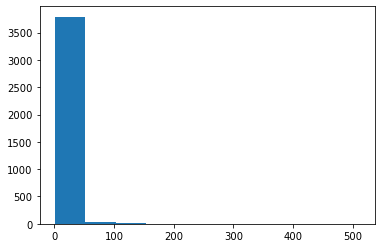

In [33]:
plt.hist(sentences_word_count)

In [35]:
# How about only the first 10 rows that took around 30minutes to run?

sentences_word_count = []
for i in all_sentences[:10]:
    for j in i:
        try:
            # using .split(' ') so that we can count the number of words instead of counting characters
            sentences_word_count.append(len(j.split(' '))) 
        except AttributeError:
            print(j)

In [36]:
min(sentences_word_count), max(sentences_word_count), np.median(sentences_word_count)

(2, 19, 8.5)

### It took around 30 minutes to analyze 10 poems with sentence length ranging between 2 to 19 (inclusive). It would take an unimaginable amount of time to run >1000 poems with sentence length ranging between 1 to 511 (with median of 7 words).

# Fortunately, running Zero-Shot Classification on the keywords generated from KeyBERT is manageable. Let's take a step back and focus on the keywords, which we have already classified earlier on in this notebook

Go to Part 3 for the final evaluation